In [1]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

cuda


In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical
%matplotlib inline

In [3]:
%tensorflow_version 2.x

# Install environment and agent
!pip install git+https://github.com/eleurent/highway-env#egg=highway-env
# !pip install stable-baselines==2.10.0

# Environment
import gym
import highway_env

# Agent
# from stable_baselines import HER, SAC, A2C

  Cloning https://github.com/eleurent/highway-env to /tmp/pip-install-fk0s8qcv/highway-env
  Running command git clone -q https://github.com/eleurent/highway-env /tmp/pip-install-fk0s8qcv/highway-env
     |████████████████████████████████| 11.5MB 11.9MB/s 
  Created wheel for highway-env: filename=highway_env-1.0.dev0-cp36-none-any.whl size=80897 sha256=e11c26a6b1a121353e349cf97c159b83659588d77e2c00cd7cbba58916e88d22
  Stored in directory: /tmp/pip-ephem-wheel-cache-g4qmsagd/wheels/e6/10/d8/02a077ca221bbac1c6fc12c1370c2f773a8cd602d4be3df0cc
Successfully built highway-env


In [4]:
!pip install gym pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
from pathlib import Path
import base64
from tqdm.notebook import trange

display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    html = []
    for mp4 in Path("video").glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 14 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,686 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 1,280 kB in 0s (11.4 MB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.8_amd6

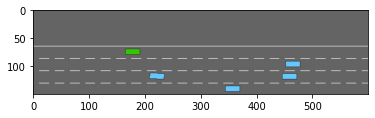

In [5]:
import gym
import highway_env
from matplotlib import pyplot as plt
%matplotlib inline

env = gym.make('highway-v0')
env.reset()
for _ in range(3):
    action = env.action_type.actions_indexes["IDLE"]
    obs, reward, done, info = env.step(action)
    env.render()

plt.imshow(env.render(mode="rgb_array"))
plt.show()

In [6]:
import pprint

env = gym.make("highway-v0")
pprint.pprint(env.config)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'initial_lane_id': None,
 'lanes_count': 4,
 'manual_control': False,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 50,
 'vehicles_density': 1}


In [7]:
env.config["duration"] = 3000
env.config["policy_frequency"] = 10
env.reset()

array([[ 1.        ,  1.        ,  0.        ,  0.41666667,  0.        ],
       [ 1.        ,  0.13176822,  0.5       , -0.01349604,  0.        ],
       [ 1.        ,  0.25094069,  0.25      , -0.02992196,  0.        ],
       [ 1.        ,  0.36336581,  0.        , -0.0147017 ,  0.        ],
       [ 1.        ,  0.48183257,  0.        , -0.01652086,  0.        ]])

In [8]:
pprint.pprint(env.config)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 3000,
 'ego_spacing': 2,
 'initial_lane_id': None,
 'lanes_count': 4,
 'manual_control': False,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 10,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 50,
 'vehicles_density': 1}


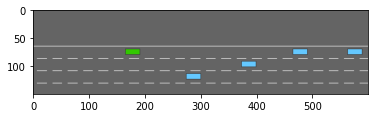

In [9]:
plt.imshow(env.render(mode="rgb_array"))
plt.show()

In [10]:
import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple
import torch as T

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Cart Pole

# parser = argparse.ArgumentParser(description='PyTorch actor-critic example')
# parser.add_argument('--gamma', type=float, default=0.99, metavar='G',
#                     help='discount factor (default: 0.99)')
# parser.add_argument('--seed', type=int, default=543, metavar='N',
#                     help='random seed (default: 543)')
# parser.add_argument('--render', action='store_true',
#                     help='render the environment')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='interval between training status logs (default: 10)')
# args = parser.parse_args()


# env = gym.make('CartPole-v1')
env.seed(1); torch.manual_seed(1);
gamma=0.99

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])


class Policy(nn.Module):
    """
    implements both actor and critic in one model
    """
    def __init__(self):
        super(Policy, self).__init__()
        self.checkpoint_file = '/content/drive/MyDrive/project3/models/model'
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.affine1 = nn.Linear(self.state_space, 128)
        self.affine2 = nn.Linear(128, 64)

        # actor's layer
        self.action_head = nn.Linear(64, self.action_space)

        # critic's layer
        self.value_head = nn.Linear(64, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        """
        forward of both actor and critic
        """
        x = F.relu(self.affine1(x))
        x = F.relu(self.affine2(x))

        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tuple of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t 
        return action_prob, state_values
    def save_checkpoint(self):
        print('... saving checkpoint ...')
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_file))


model = Policy()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
eps = np.finfo(np.float32).eps.item()
log_interval=10


def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)

    # create a categorical distribution over the list of probabilities of actions
    m = Categorical(probs)

    # and sample an action using the distribution
    action = m.sample().cpu().numpy()
    # print(action)
    # print(action[0])
    
    state_value= state_value.detach().numpy()[0]
    # index = np.argmax(action)
    action = action[0]
    # print(state_value)

    # save to action buffer
    model.saved_actions.append(SavedAction(m.log_prob(torch.Tensor([action])), torch.Tensor([state_value])))

    # the action to take (left or right)
    return action


def finish_episode():
    """
    Training code. Calculates actor and critic loss and performs backprop.
    """
    R = 0
    saved_actions = model.saved_actions
    policy_losses = [] # list to save actor (policy) loss
    value_losses = [] # list to save critic (value) loss
    returns = [] # list to save the true values

    # calculate the true value using rewards returned from the environment
    for r in model.rewards[::-1]:
        # calculate the discounted value
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):
        # print('---------')
        # print(value)
        advantage = R - value.item()

        # calculate actor (policy) loss 
        policy_losses.append(-log_prob * advantage)

        # calculate critic (value) loss using L1 smooth loss
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

    # reset gradients
    optimizer.zero_grad()

    # sum up all the values of policy_losses and value_losses
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # perform backprop
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]

def save_models(self):
    self.model.save_checkpoint()

def load_models(self):
    self.model.load_checkpoint()


In [ ]:
import csv
n_games = 20000
running_reward=10
n_steps=0
best_score = -np.inf
scores, steps_array = [], []
# run inifinitely many episodes
for i_episode in range(n_games):

  # reset environment and episode reward
  state = env.reset()
  ep_reward = 0
  
  # for each episode, only run 9999 steps so that we don't 
  # infinite loop while learning
  for t in range(1, 10000):

      # select action from policy
      action = select_action(state)
      # print(action)

      # take the action
      state, reward, done, _ = env.step(action)

      model.rewards.append(reward)
      ep_reward += reward
      n_steps +=1
      if done:
          break
  
  steps_array.append(n_steps)
  # avg_score = np.mean(scores[-100:])
  # update cumulative reward
  # running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
  # perform backprop
  finish_episode()
  scores.append(ep_reward)
  # print(scores)
  running_reward = np.mean(scores[-100:])
  print('episode: ', i_episode,'score: ', ep_reward,
             ' average score %.1f' % running_reward, 'best score %.2f' % best_score)
  # print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
  #       i_episode, ep_reward, running_reward))

        # check if we have "solved" the cart pole problem
  if running_reward > best_score:
      #if not load_checkpoint:
      model.save_checkpoint()
      best_score = running_reward
  idx_1=0
  if (i_episode)%100==0:
    print("..saving stats")

    with open('/content/drive/MyDrive/project3/stats.csv','a+') as csvfile:
      try:
        stat=list(zip(steps_array[idx_1:],scores[idx_1:]))
        writer =csv.writer(csvfile)
        for item in stat:
          writer.writerow(item)
        idx_1 =len(steps_array)
      except Exception as e:
        print(e)
        pass
      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:142: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


episode:  0 score:  123.91966776505772  average score 123.9 best score -inf
... saving checkpoint ...
..saving stats
episode:  1 score:  91.99609759773296  average score 108.0 best score 123.92
episode:  2 score:  117.50513747408478  average score 111.1 best score 123.92
episode:  3 score:  2192.4790619852756  average score 631.5 best score 123.92
... saving checkpoint ...
episode:  4 score:  2193.832383518347  average score 943.9 best score 631.47
... saving checkpoint ...
episode:  5 score:  113.09449684269407  average score 805.5 best score 943.95
episode:  6 score:  82.92570777489824  average score 702.3 best score 943.95
episode:  7 score:  48.6027685163819  average score 620.5 best score 943.95
episode:  8 score:  112.84836491883834  average score 564.1 best score 943.95
episode:  9 score:  36.353961559128436  average score 511.4 best score 943.95
episode:  10 score:  89.9580484806609  average score 473.0 best score 943.95
episode:  11 score:  113.19032710423691  average score 44

In [ ]:
model.load_checkpoint()
test=10
rewards = []
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
for i in range(test):
    state = env.reset()
    done = False
    episode_reward = 0.0
    #playing one game
    while(not done):
        action = select_action(state)
        state, reward, done, info = env.step(action)
        episode_reward += reward

    rewards.append(episode_reward)
    print('episode: ', i,'score: ', episode_reward,
             ' average score %.1f' % np.mean(rewards[-100:]))
env.close()
show_video()